In [1]:
import pandas as pd

path = "../data/dataset.csv"
def load_data(path):
    """Load dataset from a CSV file located in the specified directory."""
    return pd.read_csv(path)

In [2]:
def preprocess_data(path):
    """Preprocess data: handle missing values, encode categorical variables, etc."""
    dataset = load_data(path)
    data = dataset.rename(columns={
        'Y': 'StudentAchievementScore',
        'Z': 'GrowthMindsetIntervention',
        'S3': 'FutureSuccessExpectations',
        'C1': 'StudentRaceEthnicity',
        'C2': 'StudentGender',
        'C3': 'FirstGenCollegeStatus',
        'XC': 'SchoolUrbanicity',
        'X1': 'PreInterventionFixedMindset',
        'X2': 'SchoolAchievementLevel',
        'X3': 'SchoolMinorityComposition',
        'X4': 'PovertyConcentration',
        'X5': 'TotalStudentPopulation'
    })

    return data

In [3]:
import pandas as pd
from sklearn.ensemble import GradientBoostingRegressor

"""
The S-learner uses a single model to estimate the treatment effect by including the treatment as a feature in the model.
"""


def s_fit(data, treatment_col, outcome_col, covariate_cols):
    """
    Train an S-learner model to estimate the Conditional Average Treatment Effect (CATE).

    Parameters:
    - data: DataFrame, the preprocessed dataset
    - treatment_col: str, name of the treatment column
    - outcome_col: str, name of the outcome column
    - covariate_cols: list of str, names of the covariate columns

    Returns:
    - cate_estimates: DataFrame, containing the CATE estimates for each instance
    """

    # Create the covariates matrix and the outcome vector
    X = data[covariate_cols + [treatment_col]]
    Y = data[outcome_col]

    # Train a model on the combined data
    model = GradientBoostingRegressor(n_estimators=200, random_state=42,learning_rate= 0.1, max_depth= 3 )
    model.fit(X, Y)

    return model


def predict_outcomes(X, model, treatment_col):
    """
    Predict potential outcomes for both treatment and control groups.

    Parameters:
    - X: pd.DataFrame, feature matrix excluding the treatment variable
    - model: trained model
    - treatment_col: str, name of the treatment column

    Returns:
    - pd.DataFrame with columns 'pred_0' and 'pred_1' for control and treatment predictions.
    """
    X_control = X.copy()
    X_control[treatment_col] = 0
    pred_0 = model.predict(X_control)

    X_treatment = X.copy()
    X_treatment[treatment_col] = 1
    pred_1 = model.predict(X_treatment)

    return pd.DataFrame({'pred_0': pred_0, 'pred_1': pred_1})


def estimate_CATE(df):
    """
    Estimate the Conditional Average Treatment Effect (CATE).

    Parameters:
    - X: pd.DataFrame, feature matrix excluding the treatment variable
    - model: trained model
    - treatment_col: str, name of the treatment column

    Returns:
    - pd.Series with CATE estimates.
    """

    return df['pred_1'] - df['pred_0']

In [4]:
import pandas as pd
from sklearn.linear_model import Lasso
from sklearn.model_selection import train_test_split


def t_fit(data, treatment_col, outcome_col, covariate_cols):
    """
    Train a T-learner model to estimate the Conditional Average Treatment Effect (CATE).

    Parameters:
    - data: DataFrame, the preprocessed dataset
    - treatment_col: str, name of the treatment column
    - outcome_col: str, name of the outcome column
    - covariate_cols: list of str, names of the covariate columns

    Returns:
    - model_treated: trained model for the treated group
    - model_control: trained model for the control group
    """
    # Split the data into treatment and control groups
    treated_data = data[data[treatment_col] == 1]
    control_data = data[data[treatment_col] == 0]

    # Create the covariates matrix and the outcome vector for both groups
    X_treated = treated_data[covariate_cols]
    y_treated = treated_data[outcome_col]
    X_control = control_data[covariate_cols]
    y_control = control_data[outcome_col]

    # Train separate models on the treated and control groups
    model_treated = Lasso(alpha=0.1, random_state=42)
    model_control = Lasso(alpha=0.1, random_state=42)

    model_treated.fit(X_treated, y_treated)
    model_control.fit(X_control, y_control)

    return model_treated, model_control


def predict_outcomes_t(X, model_treated, model_control):
    """
    Predict potential outcomes for both treatment and control groups.

    Parameters:
    - X: pd.DataFrame, feature matrix excluding the treatment variable
    - model_treated: trained model for treated data
    - model_control: trained model for control data

    Returns:
    - pd.DataFrame with columns 'pred_treated' and 'pred_control'.
    """
    pred_treated = model_treated.predict(X)
    pred_control = model_control.predict(X)

    return pd.DataFrame({'pred_treated': pred_treated, 'pred_control': pred_control})


def estimate_CATE_t(df):
    """
    Estimate the Conditional Average Treatment Effect (CATE) using T-learner.

    Parameters:
    - df: pd.DataFrame, dataframe containing predictions for treated and control groups

    Returns:
    - pd.Series with CATE estimates.
    """
    return df['pred_treated'] - df['pred_control']


In [5]:
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Lasso


def x_fit(data, treatment_col, outcome_col, covariate_cols):
    """
    Train an X-learner model to estimate the Conditional Average Treatment Effect (CATE).

    Parameters:
    - data: DataFrame, the preprocessed dataset
    - treatment_col: str, name of the treatment column
    - outcome_col: str, name of the outcome column
    - covariate_cols: list of str, names of the covariate columns

    Returns:
    - cate_estimates: DataFrame, containing the CATE estimates for each instance
    """
    # Split the data into treatment and control groups
    treated_data = data[data[treatment_col] == 1]
    control_data = data[data[treatment_col] == 0]

    # Create the covariates matrix and the outcome vector for both groups
    X_treated = treated_data[covariate_cols]
    y_treated = treated_data[outcome_col]
    X_control = control_data[covariate_cols]
    y_control = control_data[outcome_col]

    # Train separate models on the treated and control groups
    model_treated = Lasso(alpha=0.1, random_state=42)
    model_control = Lasso(alpha=0.1, random_state=42)

    model_treated.fit(X_treated, y_treated)
    model_control.fit(X_control, y_control)

    return model_treated, model_control


def predict_outcomes_x(X, model_treated, model_control):
    """
    Predict potential outcomes for both treatment and control groups.

    Parameters:
    - X: pd.DataFrame, feature matrix excluding the treatment variable
    - model_treated: trained model for treated data
    - model_control: trained model for control data

    Returns:
    - pd.DataFrame with columns 'pred_treated' and 'pred_control'.
    """
    pred_treated = model_treated.predict(X)
    pred_control = model_control.predict(X)

    return pd.DataFrame({'pred_treated': pred_treated, 'pred_control': pred_control})


def estimate_CATE_x(df):
    """
    Estimate the Conditional Average Treatment Effect (CATE) using X-learner.

    Parameters:
    - df: pd.DataFrame, dataframe containing predictions for treated and control groups

    Returns:
    - pd.Series with CATE estimates.
    """
    return df['pred_treated'] - df['pred_control']


In [6]:
import pandas as pd
from sklearn.linear_model import Ridge
import numpy as np
from sklearn.model_selection import cross_val_predict

def r_fit(data, treatment_col, outcome_col, covariate_cols):
    """
    Train an R-learner model to estimate the Conditional Average Treatment Effect (CATE).

    Parameters:
    - data: DataFrame, the preprocessed dataset
    - treatment_col: str, name of the treatment column
    - outcome_col: str, name of the outcome column
    - covariate_cols: list of str, names of the covariate columns

    Returns:
    - tau_model: trained model for estimating the treatment effect
    """
    model = GradientBoostingRegressor(learning_rate=0.1, max_depth=3, n_estimators=200)
    X = data[covariate_cols]
    T = data[treatment_col]
    y = data[outcome_col]

    # Fit outcome model
    y_model = cross_val_predict(model, X, y, cv=5)

    # Fit treatment model
    t_model = cross_val_predict(model, X, T, cv=5)

    # Calculate residuals
    y_residual = y - y_model
    t_residual = T - t_model

    # Regularization of residuals
    t_residual_clipped = np.clip(t_residual, a_min=0.001, a_max=None)
    y_residual = (y_residual - np.mean(y_residual)) / np.std(y_residual)
    t_residual_clipped = (t_residual_clipped - np.mean(t_residual_clipped)) / np.std(t_residual_clipped)

    # Add a small constant to prevent division by zero
    epsilon = 1e-3 * np.std(t_residual)
    t_residual_regularized = t_residual_clipped + epsilon

    #     # Use RidgeCV or LassoCV for additional regularization in the final model
    #     regularization = 'ridge'
    #     tau_model = RidgeCV(alphas=[0.1, 1.0, 10.0])
    regularization = 'lasso'
    tau_model = Ridge(alpha=0.1)
    # Fit the treatment effect model
    division_result = y_residual / t_residual_regularized
    print(f"division result : {division_result.describe()}")

    tau_model.fit(X, y_residual / t_residual_regularized)
    print(f"tau model coefficient :{tau_model.coef_}")
    # print(f"Best alpha chosen by cross-validation: {tau_model.alpha_}")

    return tau_model, y_model, t_model, y_residual,t_residual

def predict_outcomes_r(X, tau_model, y_model, t_model):
    """
    Predict potential outcomes for both treatment and control groups.

    Parameters:
    - X: pd.DataFrame, feature matrix
    - tau_model: trained model for estimating the treatment effect
    - y_model: trained model for predicting the outcome
    - t_model: trained model for predicting the treatment

    Returns:
    - pd.Series with treatment effect estimates.
    """
    # Predict residuals
    y_residual = y_model
    t_residual = t_model

    # Predict treatment effect
    tau_pred = tau_model.predict(X)

    return pd.DataFrame({'tau_pred': tau_pred, 'y_residual': y_residual, 't_residual': t_residual})

def estimate_CATE_r(df):
    """
    Estimate the Conditional Average Treatment Effect (CATE) using R-learner.

    Parameters:
    - df: pd.DataFrame, dataframe containing predictions for treatment effect and residuals

    Returns:
    - pd.Series with CATE estimates.
    """
    return df['tau_pred']

In [7]:
# Import the necessary functions from the scripts
from models.Meta_Learners.s_Learner import s_fit, predict_outcomes, estimate_CATE
from models.Meta_Learners.x_learner import x_fit, predict_outcomes_x, estimate_CATE_x
from models.Meta_Learners.r_learner import r_fit, predict_outcomes_r, estimate_CATE_r
from models.Meta_Learners.t_learner import t_fit, predict_outcomes_t, estimate_CATE_t
from data import data_preprocessing
import pandas as pd


class TrainAndPredict:
    def __init__(self, data):
        """
        Initialize the TrainAndPredict class with the dataset.

        Parameters:
        data: pd.DataFrame, the preprocessed dataset
        """
        self.data = data

    def extract_features(self):
        """
        Extract covariates, treatment, and outcome from preprocessed data.

        Returns:
        treatment_col: str, treatment assignment column name
        outcome_col: str, outcome variable column name
        covariate_cols: list of str, covariate variable column names
        """
        # Define columns
        treatment_col = 'GrowthMindsetIntervention'
        outcome_col = 'StudentAchievementScore'
        covariate_cols = [
            'FutureSuccessExpectations', 'StudentRaceEthnicity', 'StudentGender',
            'FirstGenCollegeStatus', 'SchoolUrbanicity', 'PreInterventionFixedMindset',
            'SchoolAchievementLevel', 'SchoolMinorityComposition', 'PovertyConcentration',
            'TotalStudentPopulation'
        ]
        return treatment_col, outcome_col, covariate_cols

    def train_and_predict(self):
        """
        Train the S-Learner model and predict the CATE.

        Returns:
        CATE: pd.Series, the Conditional Average Treatment Effect estimates
        """
        treatment_col, outcome_col, covariate_cols = self.extract_features()

        # S-Learner
        s_model = s_fit(self.data, treatment_col, outcome_col, covariate_cols)
        s_predictions = predict_outcomes(self.data[covariate_cols], s_model, treatment_col)
        s_cate = estimate_CATE(s_predictions)
        data_with_s_cate = self.data.copy()
        data_with_s_cate['CATE'] = s_cate

        # T-Learner
        t_model_treated, t_model_control = t_fit(self.data, treatment_col, outcome_col, covariate_cols)
        t_predictions = predict_outcomes_t(self.data[covariate_cols], t_model_treated, t_model_control)
        t_cate = estimate_CATE_t(t_predictions)
        data_with_t_cate = self.data.copy()
        data_with_t_cate['CATE'] = t_cate

        # X-Learner
        x_model_treated, x_model_control = x_fit(self.data, treatment_col, outcome_col, covariate_cols)
        x_predictions = predict_outcomes_x(self.data[covariate_cols], x_model_treated, x_model_control)
        x_cate = estimate_CATE_x(x_predictions)
        data_with_x_cate = self.data.copy()
        data_with_x_cate['CATE'] = x_cate

        # R-Learner
        r_tau_model, r_y_model, r_t_model, y_residual, t_residual = r_fit(self.data, treatment_col, outcome_col,
                                                                          covariate_cols)
        print(y_residual.describe())
        print(t_residual.describe())
        r_predictions = predict_outcomes_r(self.data[covariate_cols], r_tau_model, r_y_model, r_t_model)
        r_cate = estimate_CATE_r(r_predictions)
        data_with_r_cate = self.data.copy()
        data_with_r_cate['CATE'] = r_cate
        # print(f"y residual{max(y_residual),min(y_residual)}, t residual {max(t_residual),min(t_residual)}")
        y_arry = pd.DataFrame(y_residual)
        t_arry = pd.DataFrame(t_residual)
        print(t_arry.describe())
        print(y_arry.describe())

        return data_with_s_cate, data_with_t_cate, data_with_x_cate, data_with_r_cate


In [8]:
# Example usage within the same script, if run as a standalone for testing:
path = '../data/dataset.csv'  # Replace with the actual path to your dataset
processed_data = data_preprocessing.preprocess_data(path)  # Get the preprocessed data
tp = TrainAndPredict(processed_data)
s_estimates, t_estimates, x_estimates, r_estimates = tp.train_and_predict()
# print(s_estimates, t_estimates, x_estimates, r_estimates)

# # Save the CATE estimates to a CSV file
# s_output_path = '../results/s_predictions.csv'
# t_output_path = '../results/t_predictions.csv'
# x_output_path = '../results/x_predictions.csv'
# r_output_path = '../results/r_predictions.csv'

# s_estimates.to_csv(s_output_path, index=False)
# t_estimates.to_csv(t_output_path, index=False)
# x_estimates.to_csv(x_output_path, index=False)
# r_estimates.to_csv(r_output_path, index=False)

division result : count    10391.000000
mean         0.267967
std          1.217603
min         -4.962407
25%         -0.434583
50%          0.267780
75%          1.016669
max          4.045960
dtype: float64
tau model coefficient :[ 0.04275259 -0.00184482 -0.00396038 -0.02451693  0.00554496 -0.06147452
 -0.00477654 -0.00125276  0.01629916  0.03119763]
count    1.039100e+04
mean    -3.555791e-17
std      1.000048e+00
min     -2.790976e+00
25%     -6.948567e-01
50%     -1.396486e-02
75%      6.634494e-01
max      3.423158e+00
Name: StudentAchievementScore, dtype: float64
count    10391.000000
mean        -0.033924
std          0.611827
min         -0.796304
25%         -0.511929
50%         -0.359347
75%          0.771510
max          1.055986
Name: GrowthMindsetIntervention, dtype: float64
       GrowthMindsetIntervention
count               10391.000000
mean                   -0.033924
std                     0.611827
min                    -0.796304
25%                    -0.511929
5

In [9]:
import pandas as pd


# Add a learner identifier column
s_estimates['Learner'] = 'S-Learner'
t_estimates['Learner'] = 'T-Learner'
x_estimates['Learner'] = 'X-Learner'
r_estimates['Learner'] = 'R-Learner'

# Combine all the estimates into one DataFrame
combined_data = pd.concat([s_estimates, t_estimates, x_estimates, r_estimates], ignore_index=True)

# Optionally, print or return the combined data
print(combined_data)

       schoolid  GrowthMindsetIntervention  StudentAchievementScore  \
0            76                          1                 0.081602   
1            76                          1                -0.385869   
2            76                          1                 0.398184   
3            76                          1                -0.175037   
4            76                          1                 0.884583   
...         ...                        ...                      ...   
41559         1                          0                 0.423366   
41560         1                          0                -0.197092   
41561         1                          0                 0.141698   
41562         1                          0                -0.351565   
41563         1                          0                 0.211240   

       FutureSuccessExpectations  StudentRaceEthnicity  StudentGender  \
0                              6                     4              2   
1

In [10]:
# List of features to calculate CATE for
features = [
     'GrowthMindsetIntervention', 'FutureSuccessExpectations',
    'StudentRaceEthnicity', 'StudentGender', 'FirstGenCollegeStatus', 'SchoolUrbanicity',
    'PreInterventionFixedMindset', 'SchoolAchievementLevel', 'SchoolMinorityComposition',
    'PovertyConcentration', 'TotalStudentPopulation'
]

# Initialize a dictionary to hold CATE results
cate_results = {}

# Function to calculate CATE for a given feature
def calculate_cate(feature):
    grouped_data = combined_data.groupby(['Learner', feature]).agg({'CATE': 'mean'}).reset_index()
    grouped_data.columns = ['Learner', feature, 'CATE']
    return grouped_data

# Calculate CATE for each feature and store the results
for feature in features:
    cate_results[feature] = calculate_cate(feature)

In [11]:
# Calculate Real-World Treatment Effects
real_world_effects = {}

for feature in features:
    # Group by the feature and treatment
    grouped_data = combined_data.groupby([feature, 'GrowthMindsetIntervention'])['StudentAchievementScore'].mean().unstack()
    
    # Calculate the real-world treatment effect as the difference between treated and control
    real_world_effect = grouped_data[1] - grouped_data[0]
    
    # Store the result
    real_world_effects[feature] = real_world_effect

                            S-Learner T-Learner R-Learner X-Learner  \
GrowthMindsetIntervention    0.244798  0.279892  0.270576  0.253454   
FutureSuccessExpectations    0.243297  0.252234  0.208768  0.212314   
StudentRaceEthnicity         0.240382  0.278262    0.2606  0.248819   
StudentGender                0.243489  0.279347  0.267875  0.251988   
FirstGenCollegeStatus        0.246866  0.280338  0.277363  0.255865   
SchoolUrbanicity             0.240176  0.278914  0.263373  0.251655   
PreInterventionFixedMindset  0.230647  0.278851  0.238911  0.240691   
SchoolAchievementLevel       0.230647  0.278851  0.238911  0.240691   
SchoolMinorityComposition    0.230647  0.278851  0.238911  0.240691   
PovertyConcentration         0.230647  0.278851  0.238911  0.240691   
TotalStudentPopulation       0.230647  0.278851  0.238911  0.240691   

                            Real-World Effect  
GrowthMindsetIntervention                 NaN  
FutureSuccessExpectations            0.252985  
Stu

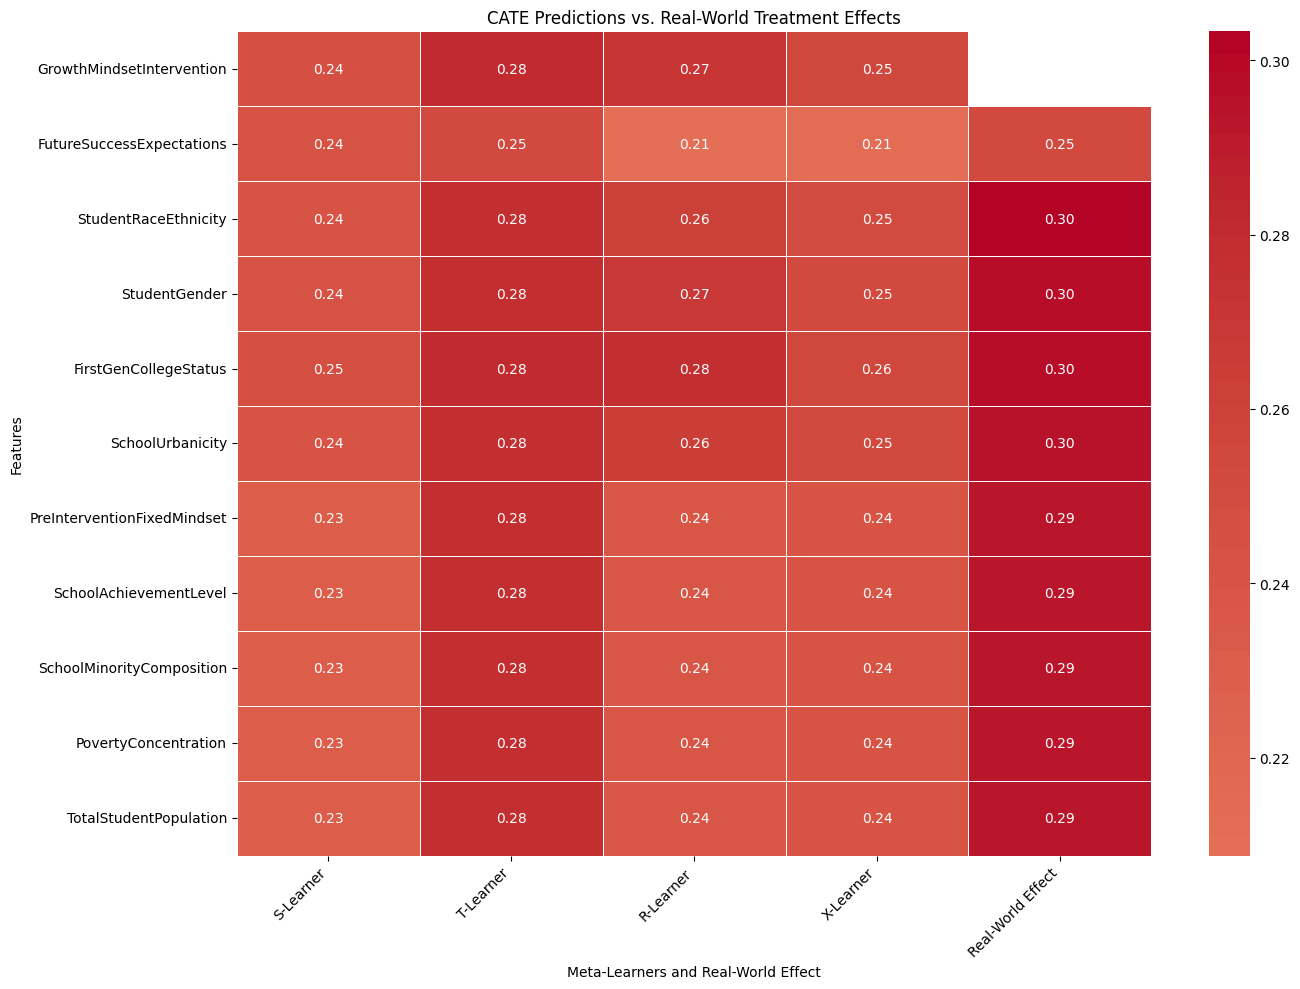

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns
# Create a new DataFrame to compare the predicted CATE with real-world treatment effects
comparison_matrix_with_real = pd.DataFrame(index=features, columns=['S-Learner', 'T-Learner', 'R-Learner', 'X-Learner', 'Real-World Effect'])

# Fill the matrix with the predicted CATE values and real-world treatment effects
for feature in features:
    for learner in ['S-Learner', 'T-Learner', 'R-Learner', 'X-Learner']:
        learner_data = cate_results[feature]
        mean_cate = learner_data[learner_data['Learner'] == learner]['CATE'].mean()
        comparison_matrix_with_real.loc[feature, learner] = mean_cate
        
    # Fill in the real-world effect for the feature
    comparison_matrix_with_real.loc[feature, 'Real-World Effect'] = real_world_effects[feature].mean()

# Display the updated comparison matrix
print(comparison_matrix_with_real)

# Visualize the Comparison
plt.figure(figsize=(14, 10))

# Heatmap showing both CATE predictions and real-world effects
sns.heatmap(comparison_matrix_with_real.astype(float), annot=True, cmap="coolwarm", center=0, cbar=True, fmt=".2f", linewidths=.5)

plt.title('CATE Predictions vs. Real-World Treatment Effects')
plt.xlabel('Meta-Learners and Real-World Effect')
plt.ylabel('Features')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()

plt.show()

In [13]:
# Step 1: Check for missing values in the relevant columns
missing_values = combined_data[['GrowthMindsetIntervention', 'StudentAchievementScore']].isnull().sum()
print("Missing values:\n", missing_values)

Missing values:
 GrowthMindsetIntervention    0
StudentAchievementScore      0
dtype: int64


In [14]:
# Step 2: Inspect data for GrowthMindsetIntervention to see if treated or control group has insufficient data
print("\nData distribution for GrowthMindsetIntervention:")
print(combined_data['GrowthMindsetIntervention'].value_counts())


Data distribution for GrowthMindsetIntervention:
GrowthMindsetIntervention
0    28028
1    13536
Name: count, dtype: int64


In [15]:
# Step 3: Investigate the distribution of StudentAchievementScore for treated and control groups
treated_scores = combined_data[combined_data['GrowthMindsetIntervention'] == 1]['StudentAchievementScore']
control_scores = combined_data[combined_data['GrowthMindsetIntervention'] == 0]['StudentAchievementScore']

In [16]:
print("\nTreated group scores (first few rows):")
print(treated_scores.head())

print("\nControl group scores (first few rows):")
print(control_scores.head())


Treated group scores (first few rows):
0    0.081602
1   -0.385869
2    0.398184
3   -0.175037
4    0.884583
Name: StudentAchievementScore, dtype: float64

Control group scores (first few rows):
3384   -1.434893
3385    0.999290
3386    0.197742
3387   -0.059160
3388   -0.041489
Name: StudentAchievementScore, dtype: float64


In [17]:
# Manually calculate the mean scores for treated and control groups
mean_treated_score = treated_scores.mean()
mean_control_score = control_scores.mean()

# Calculate the real-world effect
real_world_effect_growth_mindset = mean_treated_score - mean_control_score
print("\nManually Recalculated Real-World Effect for GrowthMindsetIntervention:", real_world_effect_growth_mindset)


Manually Recalculated Real-World Effect for GrowthMindsetIntervention: 0.3036748422490183


In [18]:
# Update the comparison matrix with the manually recalculated real-world effect
comparison_matrix_with_real.loc['GrowthMindsetIntervention', 'Real-World Effect'] = real_world_effect_growth_mindset

# Display the updated comparison matrix
print("\nUpdated comparison matrix with recalculated Real-World Effect:")
print(comparison_matrix_with_real)


Updated comparison matrix with recalculated Real-World Effect:
                            S-Learner T-Learner R-Learner X-Learner  \
GrowthMindsetIntervention    0.244798  0.279892  0.270576  0.253454   
FutureSuccessExpectations    0.243297  0.252234  0.208768  0.212314   
StudentRaceEthnicity         0.240382  0.278262    0.2606  0.248819   
StudentGender                0.243489  0.279347  0.267875  0.251988   
FirstGenCollegeStatus        0.246866  0.280338  0.277363  0.255865   
SchoolUrbanicity             0.240176  0.278914  0.263373  0.251655   
PreInterventionFixedMindset  0.230647  0.278851  0.238911  0.240691   
SchoolAchievementLevel       0.230647  0.278851  0.238911  0.240691   
SchoolMinorityComposition    0.230647  0.278851  0.238911  0.240691   
PovertyConcentration         0.230647  0.278851  0.238911  0.240691   
TotalStudentPopulation       0.230647  0.278851  0.238911  0.240691   

                            Real-World Effect  
GrowthMindsetIntervention          

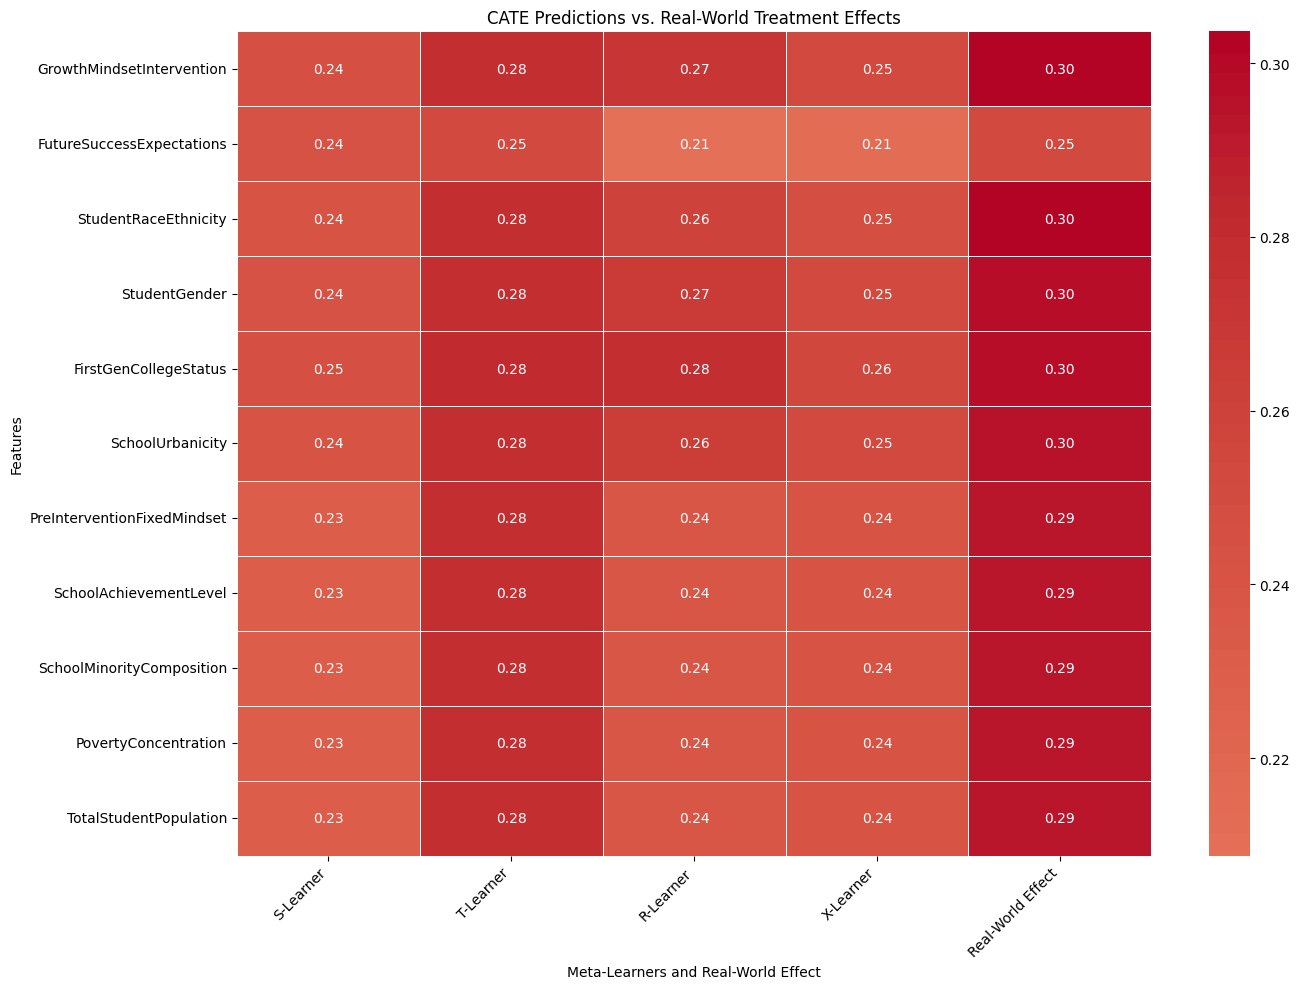

In [19]:
# Visualize the Comparison
plt.figure(figsize=(14, 10))

# Heatmap showing both CATE predictions and real-world effects
sns.heatmap(comparison_matrix_with_real.astype(float), annot=True, cmap="coolwarm", center=0, cbar=True, fmt=".2f", linewidths=.5)

plt.title('CATE Predictions vs. Real-World Treatment Effects')
plt.xlabel('Meta-Learners and Real-World Effect')
plt.ylabel('Features')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()

plt.show()


Best Learner for each feature:
                            S-Learner T-Learner R-Learner X-Learner  \
GrowthMindsetIntervention    0.244798  0.279892  0.270576  0.253454   
FutureSuccessExpectations    0.243297  0.252234  0.208768  0.212314   
StudentRaceEthnicity         0.240382  0.278262    0.2606  0.248819   
StudentGender                0.243489  0.279347  0.267875  0.251988   
FirstGenCollegeStatus        0.246866  0.280338  0.277363  0.255865   
SchoolUrbanicity             0.240176  0.278914  0.263373  0.251655   
PreInterventionFixedMindset  0.230647  0.278851  0.238911  0.240691   
SchoolAchievementLevel       0.230647  0.278851  0.238911  0.240691   
SchoolMinorityComposition    0.230647  0.278851  0.238911  0.240691   
PovertyConcentration         0.230647  0.278851  0.238911  0.240691   
TotalStudentPopulation       0.230647  0.278851  0.238911  0.240691   

                            Real-World Effect     Best Learner  
GrowthMindsetIntervention            0.303675  T-L

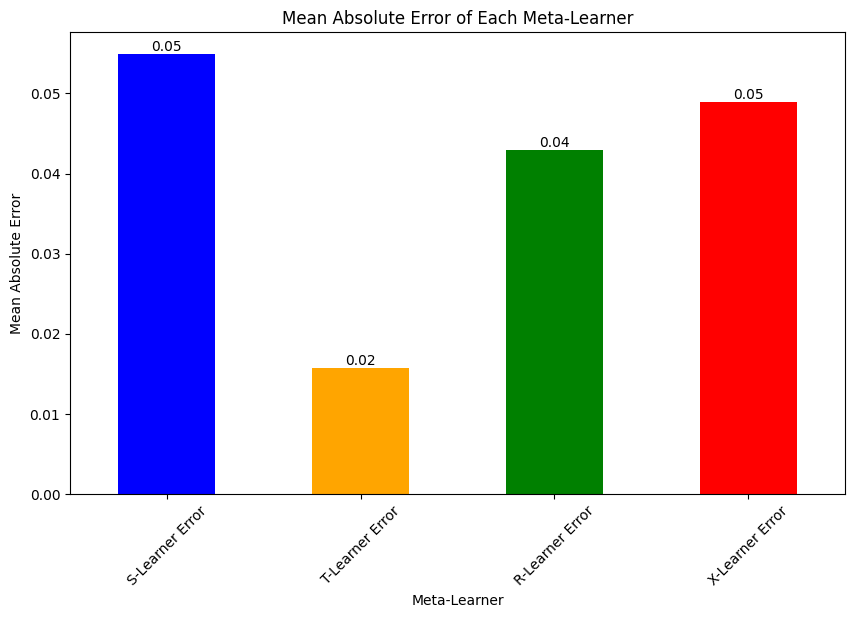


Updated comparison matrix with error calculations:
                            S-Learner T-Learner R-Learner X-Learner  \
GrowthMindsetIntervention    0.244798  0.279892  0.270576  0.253454   
FutureSuccessExpectations    0.243297  0.252234  0.208768  0.212314   
StudentRaceEthnicity         0.240382  0.278262    0.2606  0.248819   
StudentGender                0.243489  0.279347  0.267875  0.251988   
FirstGenCollegeStatus        0.246866  0.280338  0.277363  0.255865   
SchoolUrbanicity             0.240176  0.278914  0.263373  0.251655   
PreInterventionFixedMindset  0.230647  0.278851  0.238911  0.240691   
SchoolAchievementLevel       0.230647  0.278851  0.238911  0.240691   
SchoolMinorityComposition    0.230647  0.278851  0.238911  0.240691   
PovertyConcentration         0.230647  0.278851  0.238911  0.240691   
TotalStudentPopulation       0.230647  0.278851  0.238911  0.240691   

                            Real-World Effect  S-Learner Error  \
GrowthMindsetIntervention    

In [20]:
import numpy as np
import pandas as pd

# Calculate the absolute error for each learner
comparison_matrix_with_real['S-Learner Error'] = abs(comparison_matrix_with_real['S-Learner'] - comparison_matrix_with_real['Real-World Effect'])
comparison_matrix_with_real['T-Learner Error'] = abs(comparison_matrix_with_real['T-Learner'] - comparison_matrix_with_real['Real-World Effect'])
comparison_matrix_with_real['R-Learner Error'] = abs(comparison_matrix_with_real['R-Learner'] - comparison_matrix_with_real['Real-World Effect'])
comparison_matrix_with_real['X-Learner Error'] = abs(comparison_matrix_with_real['X-Learner'] - comparison_matrix_with_real['Real-World Effect'])

# Ensure all errors are numeric and handle NaN values by filling them with a large number (infinity)
comparison_matrix_with_real['S-Learner Error'] = pd.to_numeric(comparison_matrix_with_real['S-Learner Error'], errors='coerce').fillna(np.inf)
comparison_matrix_with_real['T-Learner Error'] = pd.to_numeric(comparison_matrix_with_real['T-Learner Error'], errors='coerce').fillna(np.inf)
comparison_matrix_with_real['R-Learner Error'] = pd.to_numeric(comparison_matrix_with_real['R-Learner Error'], errors='coerce').fillna(np.inf)
comparison_matrix_with_real['X-Learner Error'] = pd.to_numeric(comparison_matrix_with_real['X-Learner Error'], errors='coerce').fillna(np.inf)

# Identify the best learner for each feature by finding the minimum error
comparison_matrix_with_real['Best Learner'] = comparison_matrix_with_real[['S-Learner Error', 'T-Learner Error', 'R-Learner Error', 'X-Learner Error']].idxmin(axis=1)

print("\nBest Learner for each feature:")
print(comparison_matrix_with_real[['S-Learner', 'T-Learner', 'R-Learner', 'X-Learner', 'Real-World Effect', 'Best Learner']])

# Visualize the results using bar plots
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
mean_errors = comparison_matrix_with_real[['S-Learner Error', 'T-Learner Error', 'R-Learner Error', 'X-Learner Error']].mean()
bars = mean_errors.plot(kind='bar', color=['blue', 'orange', 'green', 'red'])

# Add the actual value at the top of each bar
for bar in bars.patches:
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height(), round(bar.get_height(), 2), 
             ha='center', va='bottom')

plt.title('Mean Absolute Error of Each Meta-Learner')
plt.ylabel('Mean Absolute Error')
plt.xlabel('Meta-Learner')
plt.xticks(rotation=45)
plt.show()

# Display the updated comparison matrix with error calculations
print("\nUpdated comparison matrix with error calculations:")
print(comparison_matrix_with_real)
